In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

%matplotlib notebook

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [3]:
#Delete outlier
train.drop(train[train['GrLivArea']>4000].index, inplace=True)

<IPython.core.display.Javascript object>


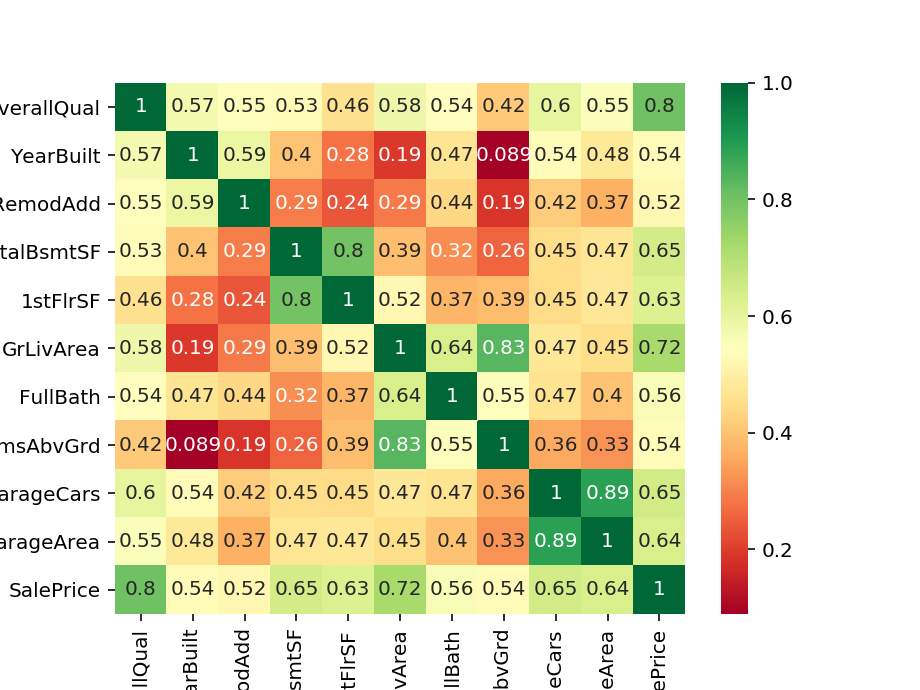

In [4]:
#Check Correlation
correlation = train.corr()
high_corr = correlation.index[abs(correlation['SalePrice'])>0.5]
sns.heatmap(train[high_corr].corr(), annot=True, cmap='RdYlGn')

<IPython.core.display.Javascript object>


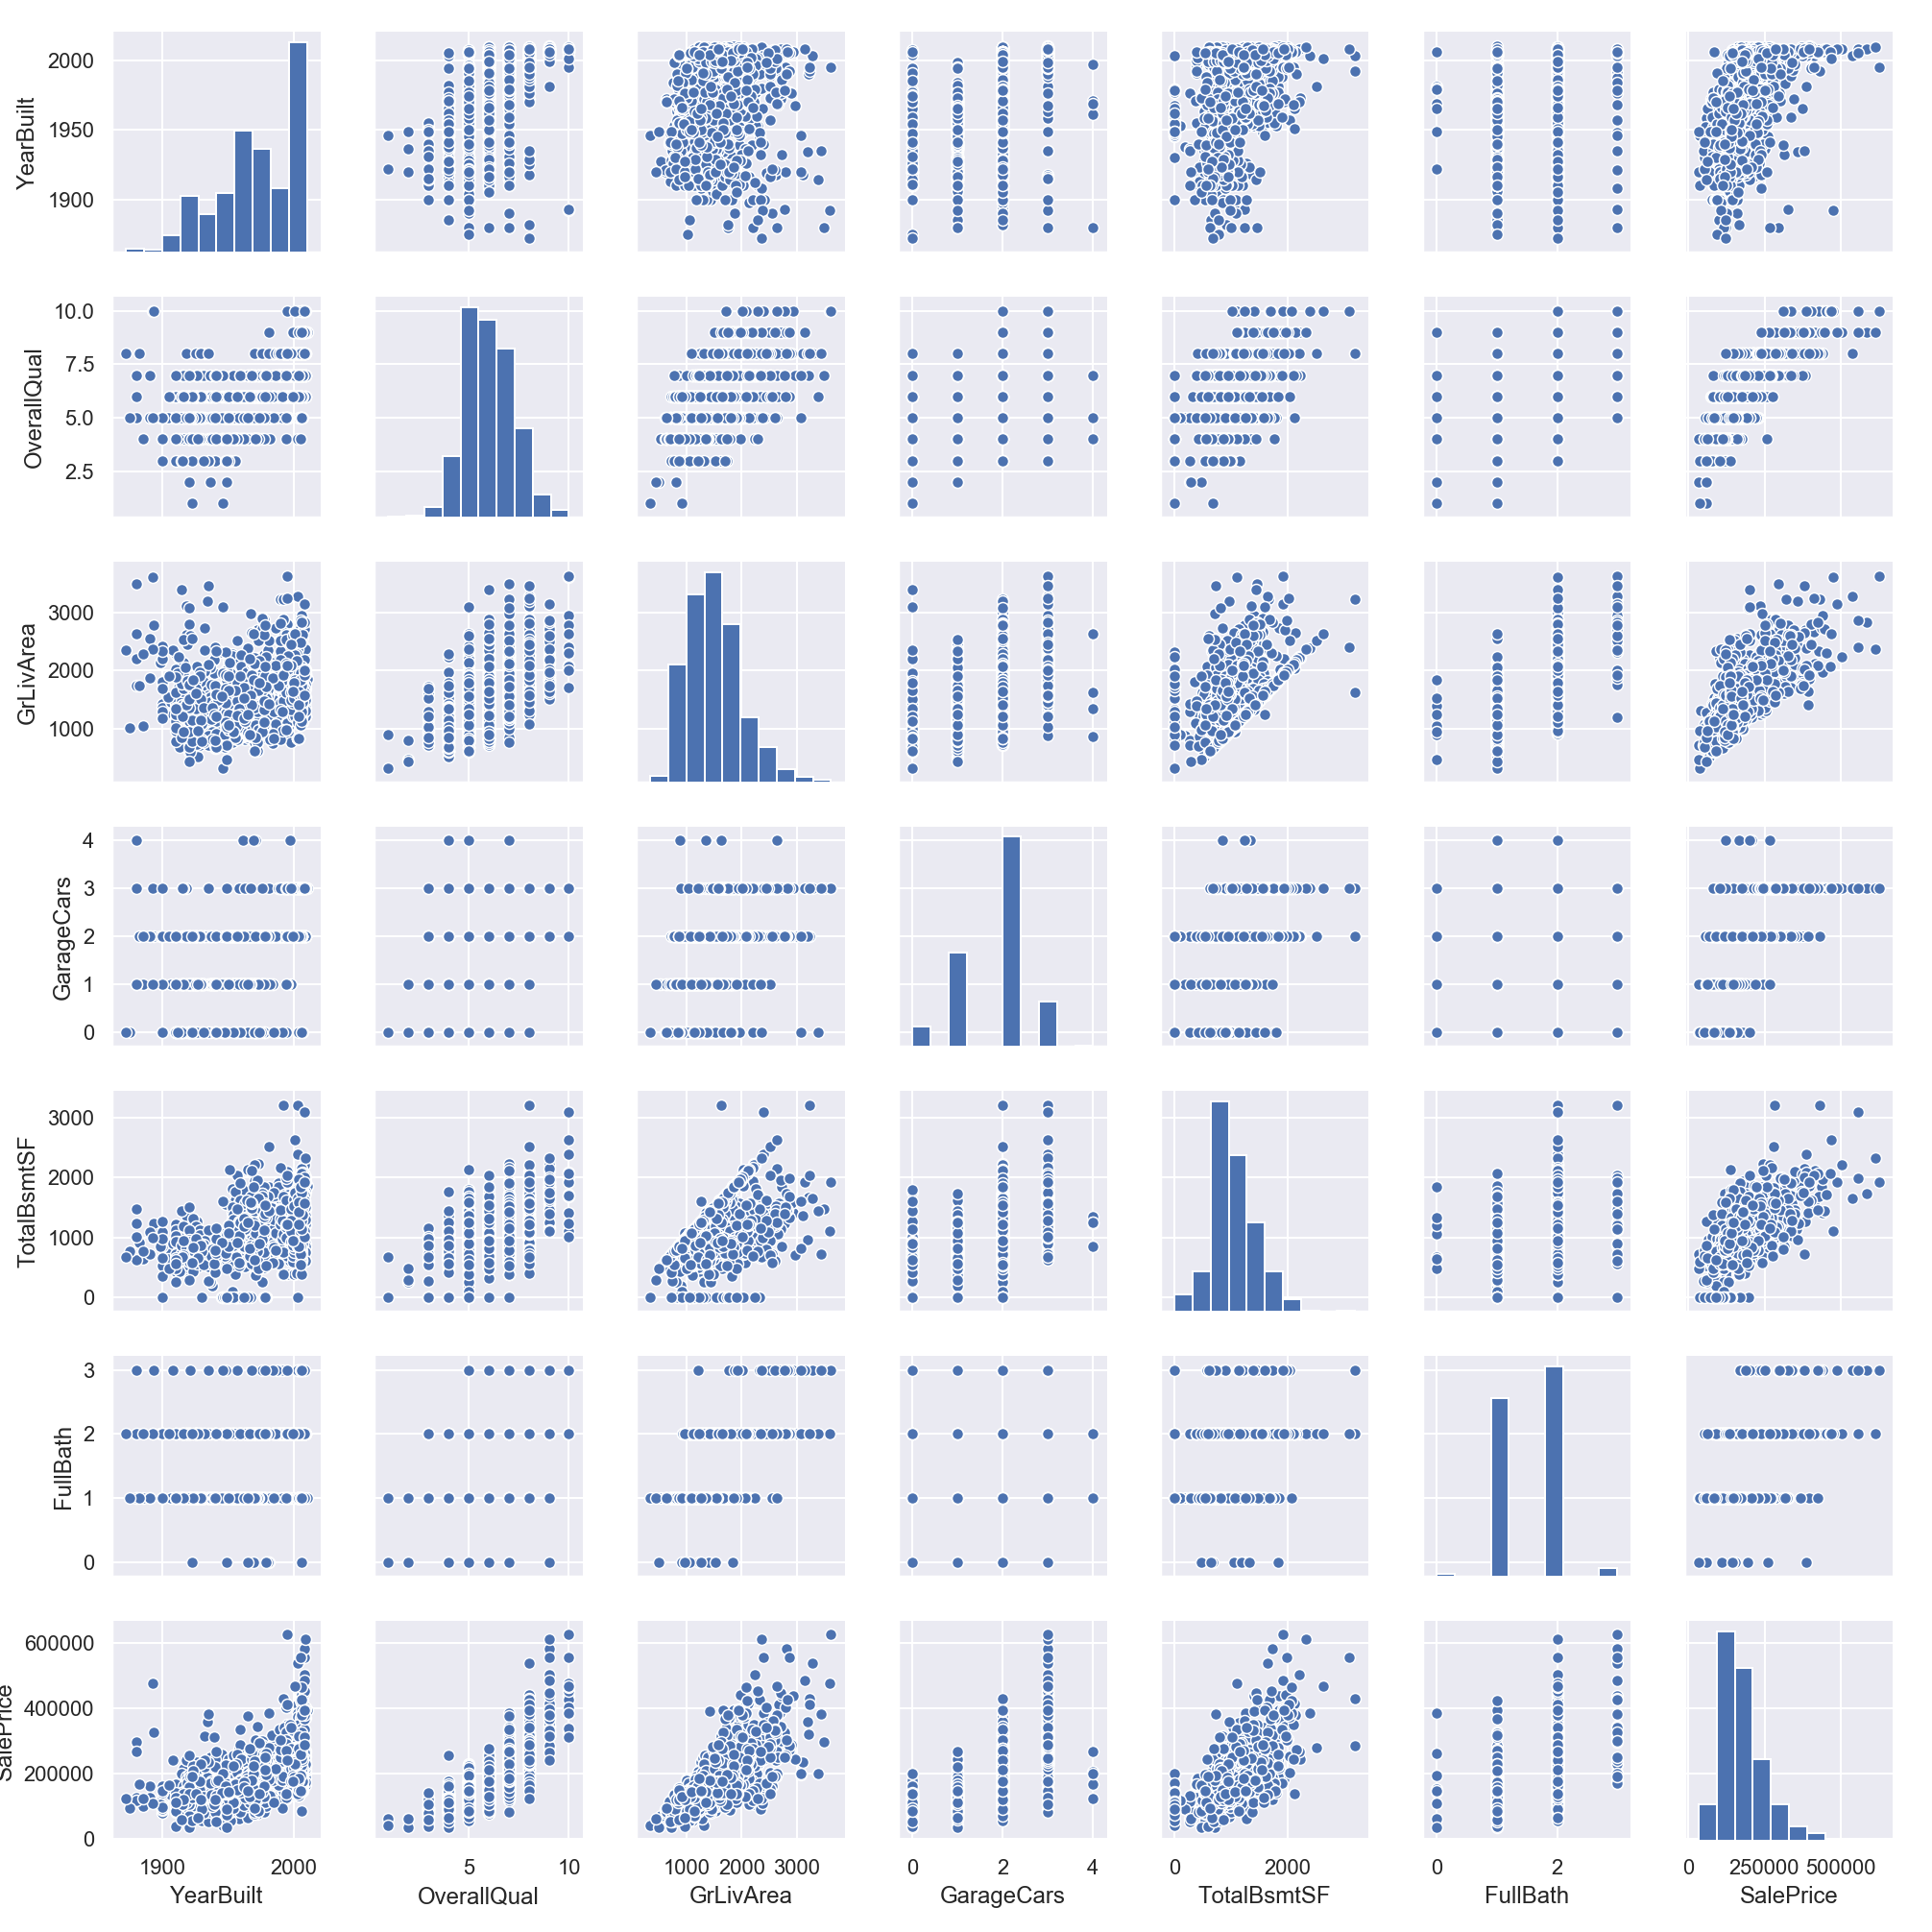

In [5]:
#scatter plot of high corr 
sns.set()
high_corr_n = ['YearBuilt', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'SalePrice']
sns.pairplot(train[high_corr_n], height=2)
plt.grid()

In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])

In [7]:
#Combine data for processing
train_r = train.shape[0]
test_r = test.shape[0]
y_train = train.SalePrice.values
data = pd.concat([train, test]).reset_index(drop=True)
data.drop('SalePrice', axis=1, inplace=True)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [8]:
#Count of Missing data
miss = data.isnull().sum()
miss[miss > 0]

Alley           2717
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2345
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2810
PoolQC          2907
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [9]:
#storing categorial and numerical variables
cat_var = [c for c in data.columns if data.dtypes[c]=='object']
num_var = [c for c in data.columns if data.dtypes[c]!='object']

In [10]:
#LotFrontage filling the missing values based on neighborhood
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [11]:
#Filling Garage missing data
grg = ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']
grg_2 = ['GarageArea',  'GarageYrBlt', 'GarageCars']

for c in grg:
    data[c] = data[c].fillna('None')
for c in grg_2:
    data[c] = data[c].fillna(0)

In [13]:
#Filling the missing basement data with 0
bsmt_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for c in bsmt_cat:
    data[c] = data[c].fillna('None') #There is not basement
bsmt_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for c in bsmt_num:
    data[c] = data[c].fillna(0)

In [14]:
#Fill missing masonary data
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
data['MasVnrType'] = data['MasVnrType'].fillna('None')

In [15]:
#Fill missing zoning data with most occurred value
#data.MSZoning.value_counts()
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

In [16]:
#All utility column values are same hence no use 
data.drop('Utilities', axis=1, inplace=True)

In [17]:
data['MSSubClass'] = data['MSSubClass'].fillna("None")

In [18]:
#Functional columns description says NA mean Typical
data['Functional'] = data['Functional'].fillna('Typ')

In [19]:
#filling missing values from categorical variables with frequent values
cat_miss = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for c in cat_miss:
    data[c] = data[c].fillna(data[c].mode()[0])

In [20]:
for c in ['Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC']:
    data[c] = data[c].fillna('None')

In [21]:
miss = data.isnull().sum()
miss[miss > 0]
#No missing values in data

Series([], dtype: int64)

In [22]:
#Some features are actually categorical but are in numerical format
for c in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
    data[c] = data[c].astype(str)

In [23]:
#Label Encoding of categorical data

cat_var = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cat_var:
    l = LabelEncoder().fit(data[c].values)
    data[c] = l.transform(list(data[c].values))
    

In [24]:
data.shape

(2915, 78)

In [25]:
#Adding total area feature
data['TotalArea'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [26]:
#Working on skewness
num_var = [c for c in data.columns if data.dtypes[c]!='object']
skew_check = data[num_var].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skew_check})

In [27]:
skewness = skewness[abs(skewness['Skew']) > 0.75]
skew_ind = skewness.index
lamb = 0.15
for c in skew_ind:
    data[c] = boxcox1p(data[c], lamb)

In [28]:
#One Hot Encoding of catgorical features
data = pd.get_dummies(data)

In [29]:
train = data[:train_r]
test = data[train_r:]

In [30]:
#Cross validation
n_fold = 5
def rmse_cv(model):
    kf=KFold(n_fold, shuffle=True, random_state=1).get_n_splits(train.values)
    rmse=np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [31]:
KRR = KernelRidge(alpha=0.65, kernel='polynomial', degree=2, coef0=2.3)
score = rmse_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1786 (0.0080)



In [32]:
rand_forest_reg = RandomForestRegressor(n_estimators = 400, max_depth=10, oob_score = True, n_jobs = -1,random_state =1)
score = rmse_cv(rand_forest_reg)
print("RandomForestRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

RandomForestRegressor score: 0.1377 (0.0033)



In [34]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmse_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1100 (0.0072)



In [35]:
ke = KRR.fit(train.values, y_train)
rfr = rand_forest_reg.fit(train.values, y_train)
lasso_m = lasso.fit(train.values, y_train)

In [36]:
finalMd = (np.expm1(lasso_m.predict(test.values)) + np.expm1(ke.predict(test.values)) + 
           np.expm1(rfr.predict(test.values))) / 3

In [37]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)